In [15]:
import torch
from torch import nn
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

torch.manual_seed(0) 

# to visualize images: Given a tensor of images, number of images, & size per image, plots and prints the images in an uniform grid.
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28), nrow=5, show=True):
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=nrow)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    if show:
        plt.show()

In [16]:
# here, values: input_dim=the dimension of the input vector, a scalar, im_chan: the number of channels of the output image, a scalar
# (MNIST is black-and-white, so 1 channel is the default), hidden_dim: the inner dimension, a scalar

class Generator(nn.Module):
    def __init__(self, input_dim=10, im_chan=1, hidden_dim=64):
        super(Generator, self).__init__()
        self.input_dim = input_dim
        # Building the neural network
        self.gen = nn.Sequential(
            self.get_gen_layers(input_dim, hidden_dim * 4, kernel_size=3, stride=2, padding=0),
            self.get_gen_layers(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1, padding=0),
            self.get_gen_layers(hidden_dim * 2, hidden_dim, kernel_size=3, stride=2, padding=0),
            self.get_gen_layers(hidden_dim, im_chan, kernel_size=4, stride=2, padding=0, final_layer=True),
        )

# Function to return a set of operations corresponding to a generator block of DCGAN:transposed convolution,batchnorm (except in final layer), 
# and ReLu activation.
    def get_gen_layers(self, input_channels, output_channels, kernel_size, stride, padding, final_layer=False):
        
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride, padding),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True),
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride, padding),
                nn.Tanh(),
            )

# Function to complete a forward pass of the generator: Given a noise tensor with dimensions (n_samples, input_dim), returns generated images.
    def forward(self, noise):
        x = noise.view(len(noise), self.input_dim, 1, 1)
        return self.gen(x)

# Function to create noise vectors: Params are dimensions (n_samples, input_dim)
# -creates a tensor of that shape filled with random numbers from the normal distribution.
def get_noise(n_samples, input_dim, device=torch.device("cuda" if torch.cuda.is_available() else "cpu")):
    return torch.randn(n_samples, input_dim, device=device)

In [17]:
# Discriminator Class Values: im_chan: number of channels of the output image (1 channel is default since MNIST is black-and-white), hidden_dim: inner dimension
class Discriminator(nn.Module):
    def __init__(self, im_chan=1, hidden_dim=64):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            self.get_disc_layers(im_chan, hidden_dim),
            self.get_disc_layers(hidden_dim, hidden_dim * 2),
            self.get_disc_layers(hidden_dim * 2, 1, final_layer=True),
        )

# Function to return a sequence of operations corresponding to a discriminator block of the DCGAN: convolution,batchnorm (except in the final layer), &
# an activation (except in the final layer).
    def get_disc_layers(self, input_channels, output_channels, kernel_size=4, stride=2, padding=0, final_layer=False):
        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride, padding),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2, inplace=True),
            )
        else:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride, padding),
            )

# Function to complete a forward pass of the discriminator: Params: Given an image tensor-a flattened image tensor with dimension (im_chan), 
# returns a 1-dimension tensor representing fake/real.
    def forward(self, image):
        disc_pred = self.disc(image)
        return disc_pred.view(len(disc_pred), -1)


In [18]:
import torch.nn.functional as F

#  Function to create one-hot vectors for the labels, returns a tensor of shape (?, num_classes-the total number of classes in the dataset)
def get_one_hot_labels(labels, n_classes):
    return F.one_hot(labels, n_classes)

In [19]:
assert (get_one_hot_labels(labels=torch.Tensor([[0, 2, 1]]).long(),n_classes=3).tolist() == [[[1, 0, 0], [0, 0, 1], [0, 1, 0]]])
print("One hot encoding working!")

One hot encoding working!


In [20]:
# Function to combine two vectors with Parameters: x (the noise vector) and y (one-hot class vector)
def combine_vectors(x, y):
    combined = torch.cat((x,y),dim=1)
    return combined

In [21]:
assert tuple(combine_vectors(torch.randn(1, 4, 5), torch.randn(1, 8, 5)).shape) == (1, 12, 5)
assert tuple(combine_vectors(torch.randn(1, 10, 12).long(), torch.randn(1, 20, 12).long()).shape) == (1, 30, 12)
print("Combine vectors working!")

Combine vectors working!


In [22]:
mnist_shape = (1, 28, 28)
n_classes = 10

In [23]:
criterion = nn.BCEWithLogitsLoss()
n_epochs = 50
z_dim = 64
display_step = 1000
batch_size = 128
lr = 0.001
# device = 'cuda'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

dataloader = DataLoader(
    MNIST('.', download=True, transform=transform),
    batch_size=batch_size,
    shuffle=True)

In [24]:
# Function to get the size of the conditional input dimensions from Parameters:z_dim(the dimension of the noise vector), 
# mnist_shape: the shape of each MNIST image as (C, W, H) and n_classes: the total number of classes in the dataset
# Returns= generator_input_dim: the input dimensionality of the conditional generator, which takes the noise and class vectors
#         discriminator_im_chan: the number of input channels to the discriminator (e.g. C x 28 x 28 for MNIST)
def get_input_dimensions(z_dim, mnist_shape, n_classes):
    generator_input_dim = z_dim + n_classes
    discriminator_im_chan = mnist_shape[0] + n_classes
    return generator_input_dim, discriminator_im_chan

In [25]:
def test_input_dimensions():
    generator_dim, discriminator_dim = get_input_dimensions(23, (12, 23, 52), 9)
    assert generator_dim == 32
    assert discriminator_dim == 21
test_input_dimensions()
print("Input dimensions satisfied!")

Input dimensions satisfied!


In [26]:
generator_input_dim, discriminator_im_chan = get_input_dimensions(z_dim, mnist_shape, n_classes)

gen = Generator(input_dim=generator_input_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
disc = Discriminator(im_chan=discriminator_im_chan).to(device)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

# Initializing the weights of the network using samples from a normal distribution with mean 0 and standard deviation 0.02
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

  0%|          | 0/469 [00:00<?, ?it/s]

Model working.


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 1000: Generator loss: 3.415349692225456, discriminator loss: 0.1986933038700372


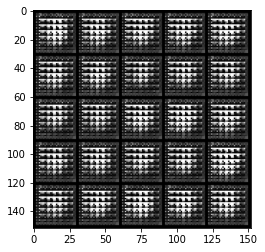

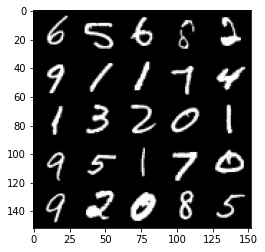

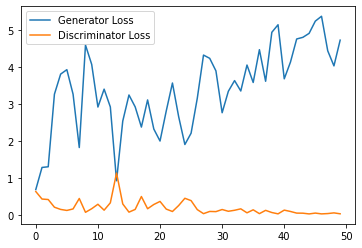

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 2000: Generator loss: 4.395762840270996, discriminator loss: 0.11032006802782417


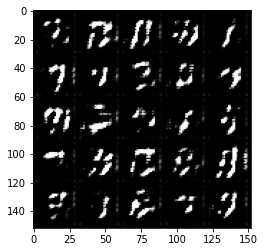

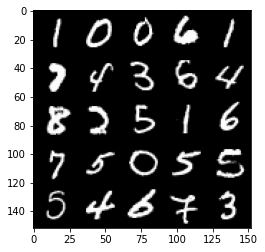

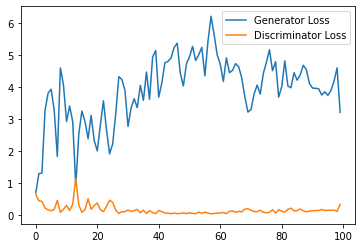

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 3000: Generator loss: 3.699116611242294, discriminator loss: 0.19887693683803082


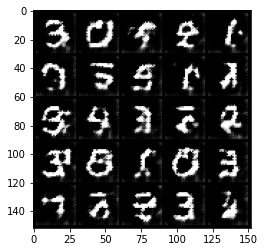

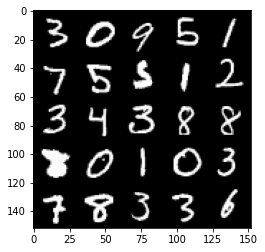

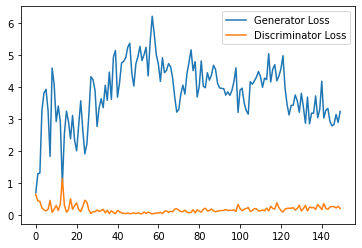

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 4000: Generator loss: 2.9425386142730714, discriminator loss: 0.28411015712842347


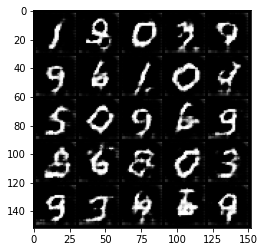

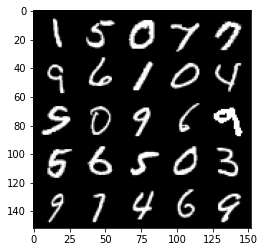

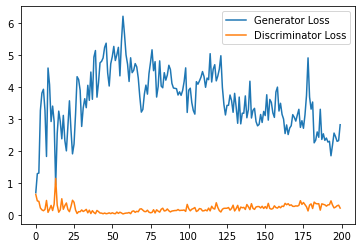

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 5000: Generator loss: 2.4884381017684936, discriminator loss: 0.33300375202298166


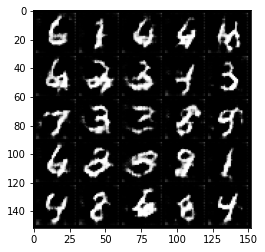

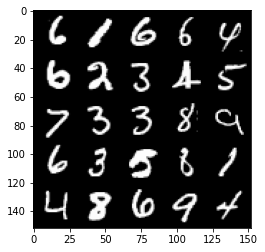

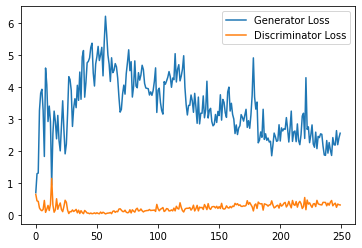

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 6000: Generator loss: 2.1575763387680054, discriminator loss: 0.3670467778146267


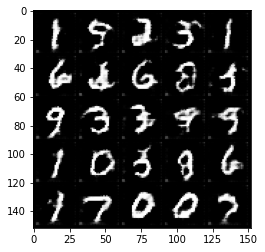

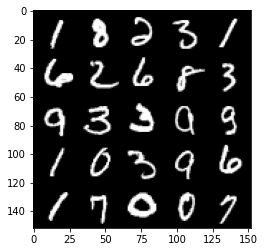

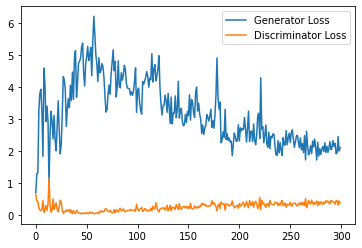

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 7000: Generator loss: 1.8250145111083984, discriminator loss: 0.4349312027692795


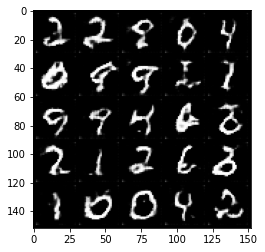

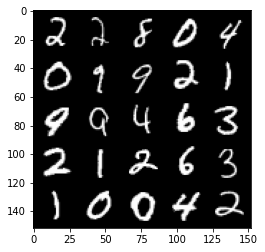

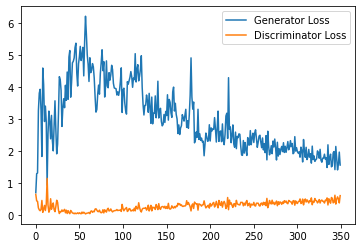

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 8000: Generator loss: 1.6383981292247771, discriminator loss: 0.4915614301264286


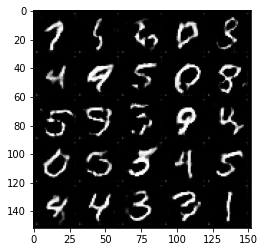

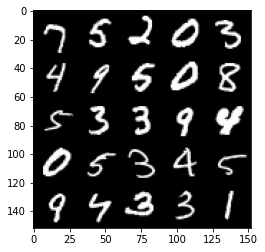

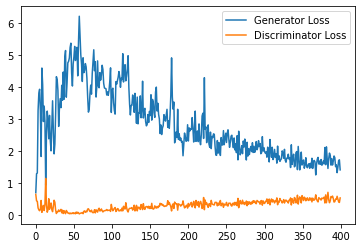

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 9000: Generator loss: 1.5055263000130654, discriminator loss: 0.5284377142190934


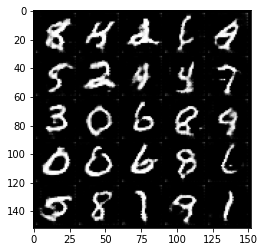

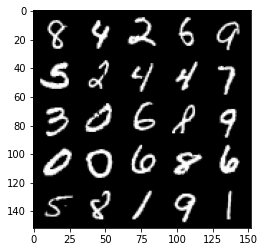

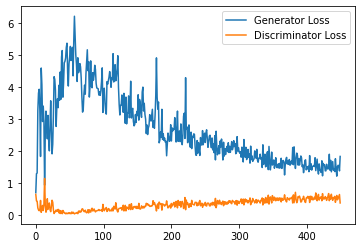

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 10000: Generator loss: 1.3599131364822388, discriminator loss: 0.5368752400279045


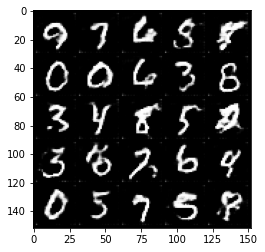

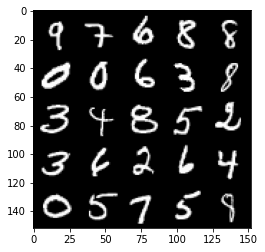

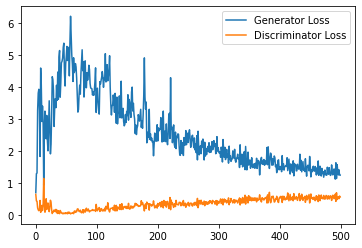

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 11000: Generator loss: 1.3919813306331634, discriminator loss: 0.5343789459466934


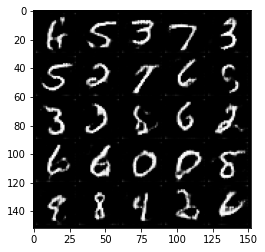

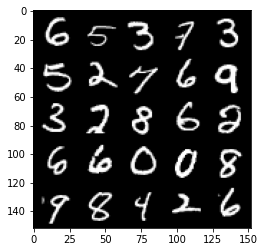

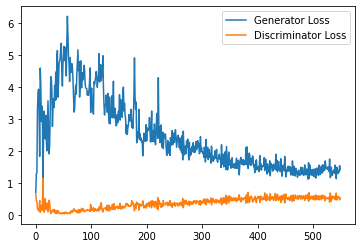

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 12000: Generator loss: 1.297436163187027, discriminator loss: 0.5558028597533703


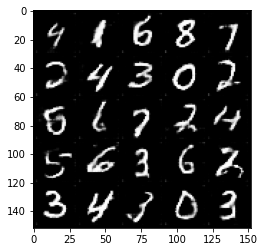

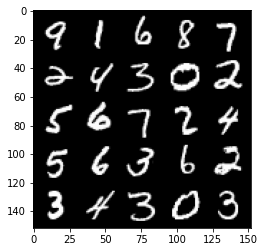

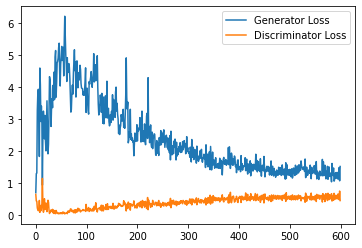

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 13000: Generator loss: 1.2327185480594636, discriminator loss: 0.5733266284167766


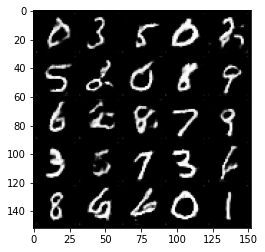

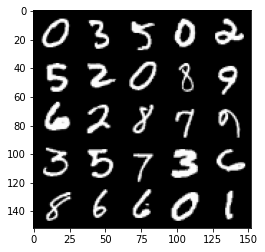

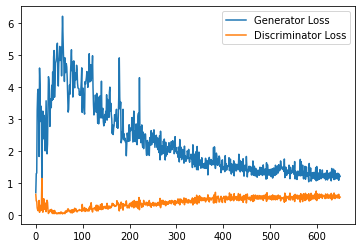

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 14000: Generator loss: 1.2312734600305557, discriminator loss: 0.5773475203216076


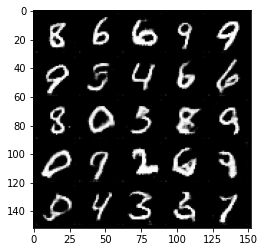

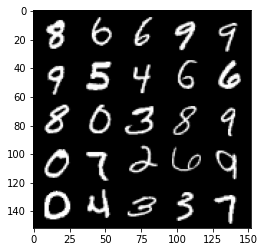

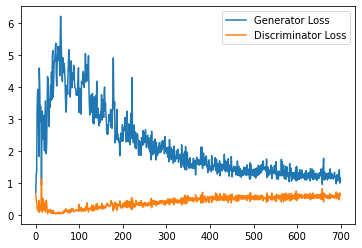

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 15000: Generator loss: 1.162364479124546, discriminator loss: 0.5878446555733681


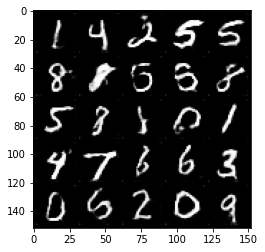

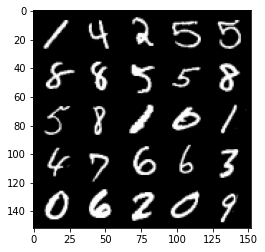

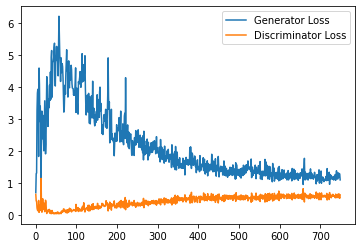

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 16000: Generator loss: 1.1490956255793572, discriminator loss: 0.5964008955657483


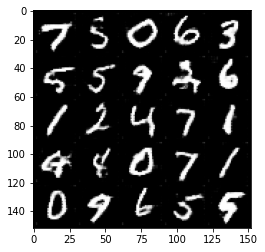

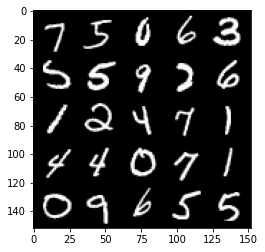

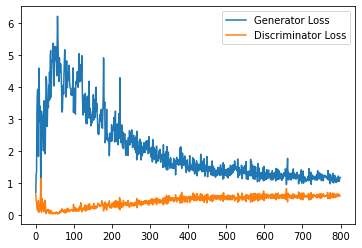

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 17000: Generator loss: 1.1057717537879943, discriminator loss: 0.5905390372872352


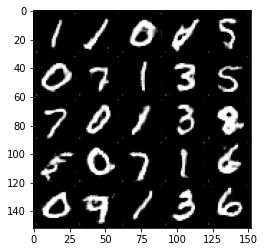

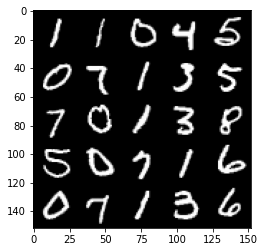

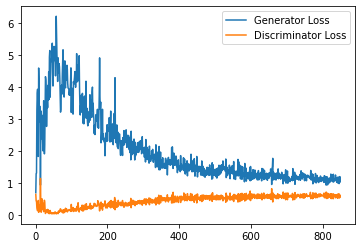

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 18000: Generator loss: 1.1471202627420425, discriminator loss: 0.5880971095561981


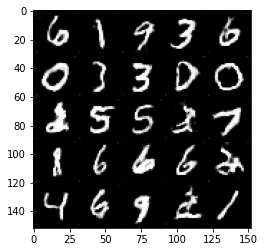

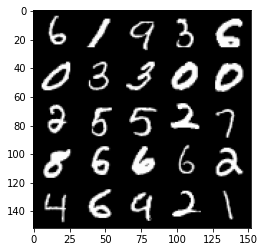

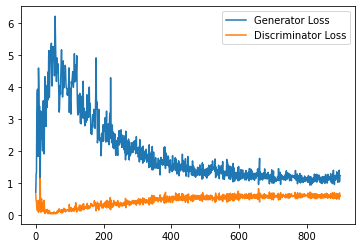

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 19000: Generator loss: 1.1243578232526779, discriminator loss: 0.5814047155678272


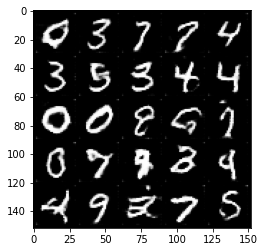

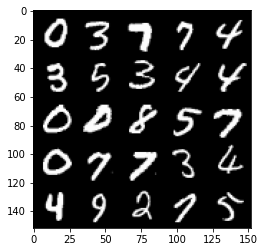

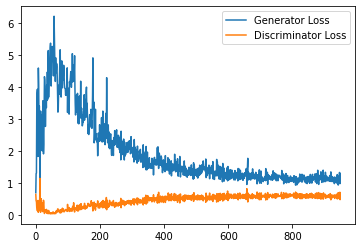

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 20000: Generator loss: 1.1370221589803695, discriminator loss: 0.5777947941124439


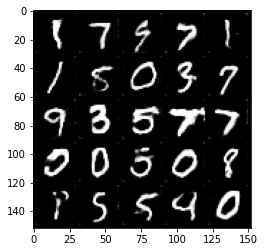

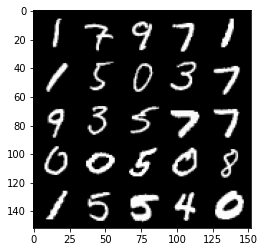

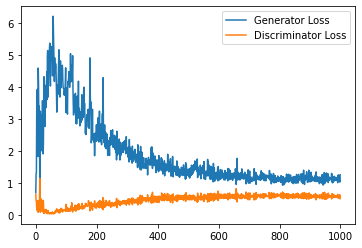

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 21000: Generator loss: 1.1576446150541306, discriminator loss: 0.5763130297660828


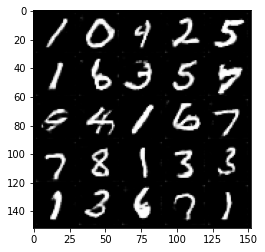

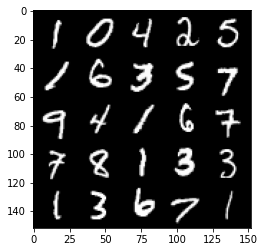

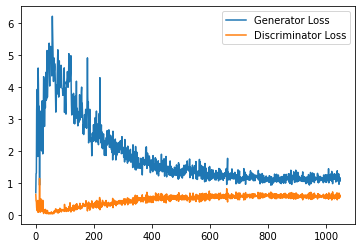

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 22000: Generator loss: 1.1160210345983506, discriminator loss: 0.579301262140274


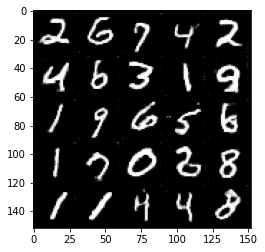

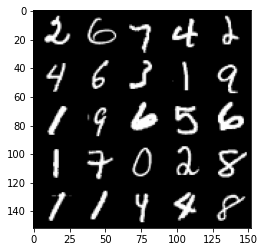

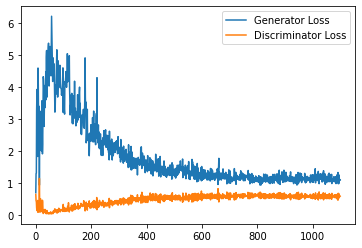

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 23000: Generator loss: 1.1545305495262146, discriminator loss: 0.5756219814419746


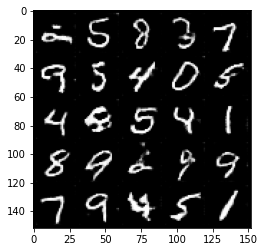

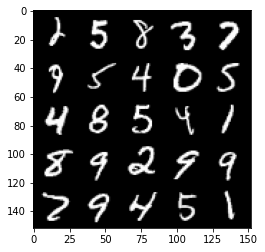

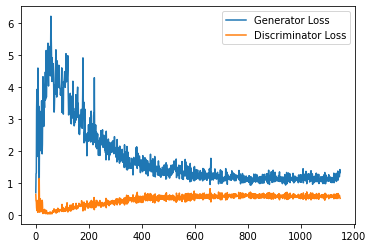

In [27]:
cur_step = 0
generator_losses = []
discriminator_losses = []

noise_and_labels = False
fake = False

fake_image_and_labels = False
real_image_and_labels = False
disc_fake_pred = False
disc_real_pred = False

for epoch in range(n_epochs):
    # Dataloader returns the batches and the labels
    for real, labels in tqdm(dataloader):
        cur_batch_size = len(real)
        # Flatten the batch of real images from the dataset
        real = real.to(device)

        one_hot_labels = get_one_hot_labels(labels.to(device), n_classes)
        image_one_hot_labels = one_hot_labels[:, :, None, None]
        image_one_hot_labels = image_one_hot_labels.repeat(1, 1, mnist_shape[1], mnist_shape[2])

        # Zeroing out the discriminator gradients
        disc_opt.zero_grad()
        # Get noise corresponding to the current batch_size 
        fake_noise = get_noise(cur_batch_size, z_dim, device=device)
        
        # get the images from the generator
        # Steps: 1) Combine the noise vectors and the one-hot labels for the generator
        #        2) Generate the conditioned fake images
       
        noise_and_labels = torch.cat((fake_noise, one_hot_labels), dim=1)
        fake = gen(noise_and_labels)
        
        # ensuring that enough images were generated
        assert len(fake) == len(real)

        # get the predictions from the discriminator
        # Steps: 1) Create the input for the discriminator: a) Combine the fake images with image_one_hot_labels, 
        #           b) Combine the real images with image_one_hot_labels
        #        2) Get the discriminator's prediction on the fakes as disc_fake_pred
        #        3) Get the discriminator's prediction on the reals as disc_real_pred
        
        fake_image_and_labels = combine_vectors(fake.detach(), image_one_hot_labels)
        real_image_and_labels = combine_vectors(real, image_one_hot_labels)
        disc_fake_pred = disc(fake_image_and_labels)
        disc_real_pred = disc(real_image_and_labels)
        
        # ensuring that enough predictions were made
        assert len(disc_real_pred) == len(real)
        # ensuring that the inputs are different
        assert torch.any(fake_image_and_labels != real_image_and_labels)

        disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
        disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
        disc_loss = (disc_fake_loss + disc_real_loss) / 2
        disc_loss.backward(retain_graph=True)
        disc_opt.step() 

        # Keeping track of the average discriminator loss
        discriminator_losses += [disc_loss.item()]

        # Zeroing out the generator gradients
        gen_opt.zero_grad()

        fake_image_and_labels = combine_vectors(fake, image_one_hot_labels)
        disc_fake_pred = disc(fake_image_and_labels)
        gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
        gen_loss.backward()
        gen_opt.step()

        generator_losses += [gen_loss.item()]

        if cur_step % display_step == 0 and cur_step > 0:
            gen_mean = sum(generator_losses[-display_step:]) / display_step
            disc_mean = sum(discriminator_losses[-display_step:]) / display_step
            print(f"Step {cur_step}: Generator loss: {gen_mean}, discriminator loss: {disc_mean}")
            show_tensor_images(fake)
            show_tensor_images(real)
            step_bins = 20
            x_axis = sorted([i * step_bins for i in range(len(generator_losses) // step_bins)] * step_bins)
            num_examples = (len(generator_losses) // step_bins) * step_bins
            plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(generator_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Generator Loss"
            )
            plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(discriminator_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Discriminator Loss"
            )
            plt.legend()
            plt.show()
        elif cur_step == 0:
            print("Model working.")
        cur_step += 1

In [28]:
gen = gen.eval()

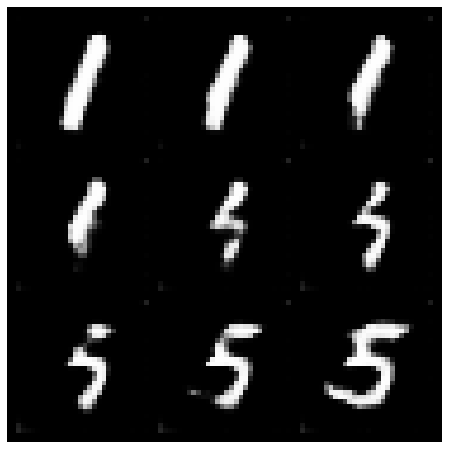

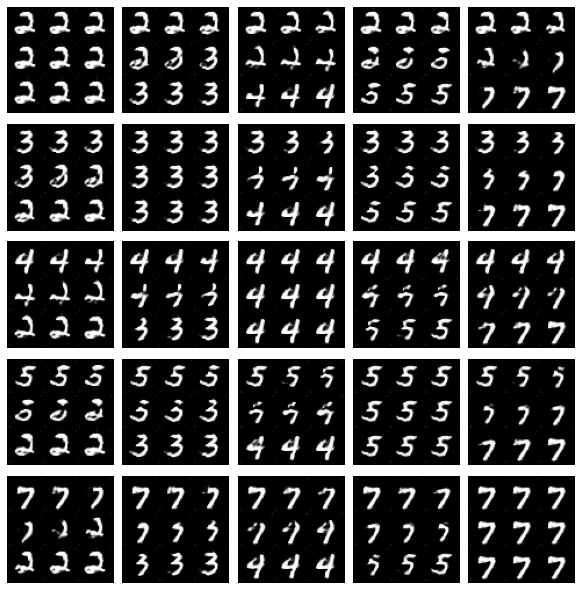

In [29]:
import math

n_interpolation = 9 
interpolation_noise = get_noise(1, z_dim, device=device).repeat(n_interpolation, 1)

def interpolate_class(first_number, second_number):
    first_label = get_one_hot_labels(torch.Tensor([first_number]).long(), n_classes)
    second_label = get_one_hot_labels(torch.Tensor([second_number]).long(), n_classes)

    # Calculate the interpolation vector between the two labels
    percent_second_label = torch.linspace(0, 1, n_interpolation)[:, None]
    interpolation_labels = first_label * (1 - percent_second_label) + second_label * percent_second_label

    # Combine the noise and the labels
    noise_and_labels = combine_vectors(interpolation_noise, interpolation_labels.to(device))
    fake = gen(noise_and_labels)
    show_tensor_images(fake, num_images=n_interpolation, nrow=int(math.sqrt(n_interpolation)), show=False)

start_plot_number = 1
end_plot_number = 5 

plt.figure(figsize=(8, 8))
interpolate_class(start_plot_number, end_plot_number)
_ = plt.axis('off')

# visualizing a set of pairwise class interpolations for a collection of different numbers, all in a single grid of interpolations.
plot_numbers = [2, 3, 4, 5, 7]
n_numbers = len(plot_numbers)
plt.figure(figsize=(8, 8))
for i, first_plot_number in enumerate(plot_numbers):
    for j, second_plot_number in enumerate(plot_numbers):
        plt.subplot(n_numbers, n_numbers, i * n_numbers + j + 1)
        interpolate_class(first_plot_number, second_plot_number)
        plt.axis('off')
plt.subplots_adjust(top=1, bottom=0, left=0, right=1, hspace=0.1, wspace=0)
plt.show()
plt.close()

In [ ]:
n_interpolation = 3

# This time we're interpolating between the noise instead of the labels
interpolation_label = get_one_hot_labels(torch.Tensor([5]).long(), n_classes).repeat(n_interpolation, 1).float()

def interpolate_noise(first_noise, second_noise):
    percent_first_noise = torch.linspace(0, 1, n_interpolation)[:, None].to(device)
    interpolation_noise = first_noise * percent_first_noise + second_noise * (1 - percent_first_noise)

    # Combining the noise and the labels again
    noise_and_labels = combine_vectors(interpolation_noise, interpolation_label).to(device)
    fake = gen(noise_and_labels)
    show_tensor_images(fake, num_images=n_interpolation, nrow=int(math.sqrt(n_interpolation)), show=False)

# Generating noise vectors to interpolate between
n_noise = 2 
plot_noises = [get_noise(1, z_dim, device=device) for i in range(n_noise)]
plt.figure(figsize=(8, 8))
for i, first_plot_noise in enumerate(plot_noises):
    for j, second_plot_noise in enumerate(plot_noises):
        plt.subplot(n_noise, n_noise, i * n_noise + j + 1)
        interpolate_noise(first_plot_noise, second_plot_noise)
        plt.axis('off')
plt.subplots_adjust(top=1, bottom=0, left=0, right=1, hspace=0.1, wspace=0)
plt.show()
plt.close()

In [33]:
# References and credits: 
# https://www.kaggle.com/code/amoghjrules/build-gan-assignment-4/notebook ,
# https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-an-mnist-handwritten-digits-from-scratch-in-keras/

In [34]:
# Deliverables:

# 5) Can you guess why was batch-normalization used in the last layers of the Discriminator and Generator?
# answer-> Batch normalization is often used in deep learning models to stabilize the training process and accelerate convergence. In the case of GANs, batch 
# normalization can be used in both the generator and discriminator networks to improve their performance.In the discriminator network, batch normalization
# is typically applied to the last layer to normalize the activations and reduce the internal covariate shift. This can help prevent the discriminator 
# from getting stuck in local optima and improve its ability to discriminate between real and fake samples.
# In the generator network, batch normalization is often applied to all layers except for the output layer. This helps to stabilize the gradients and 
# reduce the risk of vanishing or exploding gradients, which can lead to poor quality generated images.

# 6) Why was backpropagation done only on Discriminator and not on Generator in Step-1. Explain briefly.
# answer-> In the first step of training a GAN, the discriminator network is trained on a batch of real and fake samples. Backpropagation is used to compute 
# the gradients of the loss function with respect to the parameters of the discriminator network, and these gradients are used to update the parameters 
# through gradient descent. The generator network is not trained in this step, and backpropagation is not used on it. This is because the goal of the 
# first step is to train the discriminator to better distinguish between real and fake samples, and the generator is not yet involved in this process.
# Instead, the generator is used to produce fake samples that are fed into the discriminator. The discriminator is then trained to correctly identify 
# these fake samples as fake, while also correctly identifying the real samples as real. This creates a feedback loop between the generator and 
# discriminator, where the generator tries to produce better fake samples to fool the discriminator, and the discriminator tries to improve its ability 
# to distinguish between real and fake samples. Once the discriminator has been trained in the first step, the second step involves training the generator. 
# Backpropagation is used on the generator in this step to compute the gradients of the loss function with respect to the generator's parameters, and 
# these gradients are used to update the generator's parameters through gradient descent. The goal of this step is to train the generator to produce 
# better fake samples that can fool the discriminator.